# Lawnmower

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/lawnmower.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The simplest method for _coverage_ is the "lawnmower" pattern, back and forth in strips.  Sounds simple but it can become slightly complicated for weird shaped fields.  This notebook uses the [`shapely` Python library](https://shapely.readthedocs.io/en/stable/) to do the necessary manipulation of shapes, especially splitting and rotating.

> This is technically termed the _boustrophedon_ from the Greek "the way the ox turns" in reference to ploughing a field 

In [311]:
import shapely
import shapely.ops
import shapely.plotting
import shapely.affinity
import numpy
import matplotlib.pyplot as plt

Begin by defining a polygon.

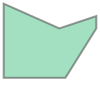

In [312]:
my_poly = shapely.Polygon([(0,0),(10,0),(15,8),(15,10),(9,8),(0,12)])
my_poly

Our first task is to divide it into segments of equal width, done using shapely's `split` command.

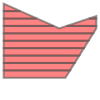

In [313]:
def split_poly(poly,width):
    x_min,y_min,x_max,y_max = poly.bounds
    y_splits = numpy.arange(y_min+width,y_max,width)
    res = poly
    for y in y_splits:
        split_line = shapely.LineString([(x_min,y),(x_max,y)])
        res = shapely.MultiPolygon(shapely.ops.split(res,split_line))
    return res

splits = split_poly(my_poly,1.2)
splits

For a typical drone surveying mission, we need to cover each of those segments with our camera field of view.  This means we need to place rectangular strips over each segment, to make sure we don't miss anything.

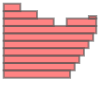

In [314]:
def make_strips(splits):
    return shapely.MultiPolygon([g.envelope for g in splits.geoms])

strips = make_strips(splits)
strips

Next we need to build a path that covers every strip.  The simplest way is to take the strips in the order they were generated, alternating direction each time.

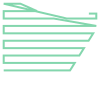

In [315]:
def build_path_simple(strips):
    points = []
    for i,s in enumerate(strips.geoms):
        x_min,y_min,x_max,y_max = s.bounds
        pt_left = shapely.Point(x_min,0.5*(y_min+y_max))
        pt_right = shapely.Point(x_max,0.5*(y_min+y_max))
        if i%2==0:
            points.append(pt_left)
            points.append(pt_right)
        else:
            points.append(pt_right)
            points.append(pt_left)
    return shapely.LineString(points)

path = build_path_simple(strips)
path

Weird?  Let's look at it on a clearer plot.

Text(0.5, 1.0, 'Length=143.2')

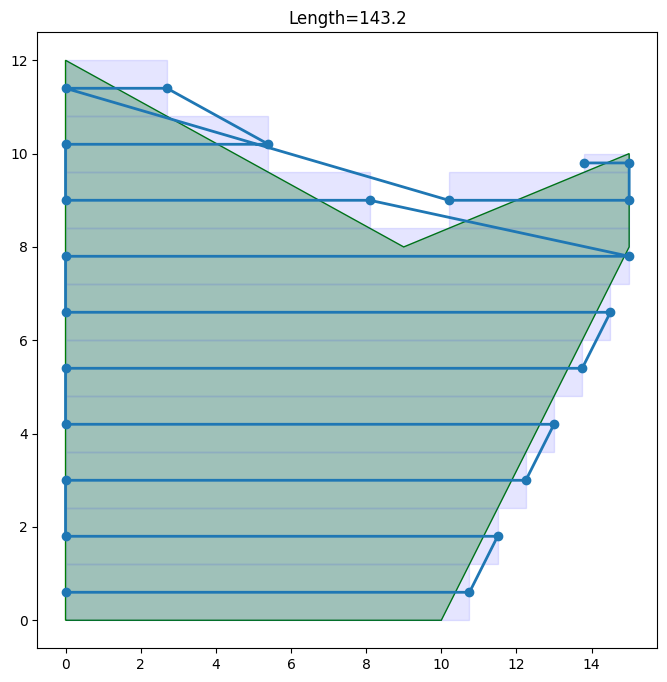

In [316]:
_, ax =plt.subplots(figsize=(8,8))
shapely.plotting.plot_polygon(my_poly,ax=ax,color='g',add_points=False)
shapely.plotting.plot_polygon(strips,ax=ax,color='b',alpha=0.1,add_points=False)
shapely.plotting.plot_line(path,ax=ax)
ax.set_title(f'Length={path.length:.1f}')

It seems we cannot rely upon the splitting algorithm to produce an efficient order.  A better way would be to to a greedy search, starting from one point and always moving to the nearest uncovered strip.

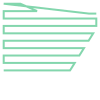

In [317]:
def build_path_greedy(strips):
    pairs = []
    for i,s in enumerate(strips.geoms):
        x_min,y_min,x_max,y_max = s.bounds
        pt_left = shapely.Point(x_min,0.5*(y_min+y_max))
        pt_right = shapely.Point(x_max,0.5*(y_min+y_max))
        pairs.append((pt_left,pt_right))
    path = []
    current_pt = shapely.Point(0,0)
    while pairs:
        dists = [(current_pt.distance(pt_left),current_pt.distance(pt_right)) for pt_left,pt_right in pairs]
        next_strip = numpy.argmin([min(ds) for ds in dists])
        next_end = numpy.argmin(dists[next_strip])
        path.append(pairs[next_strip][next_end])
        path.append(pairs[next_strip][1-next_end])
        current_pt = pairs[next_strip][1-next_end]
        pairs.pop(next_strip)
    return shapely.LineString(path)

path = build_path_greedy(strips)
path

Looks better, perhaps still a little weird.  A closer look...

Text(0.5, 1.0, 'Length=142.1')

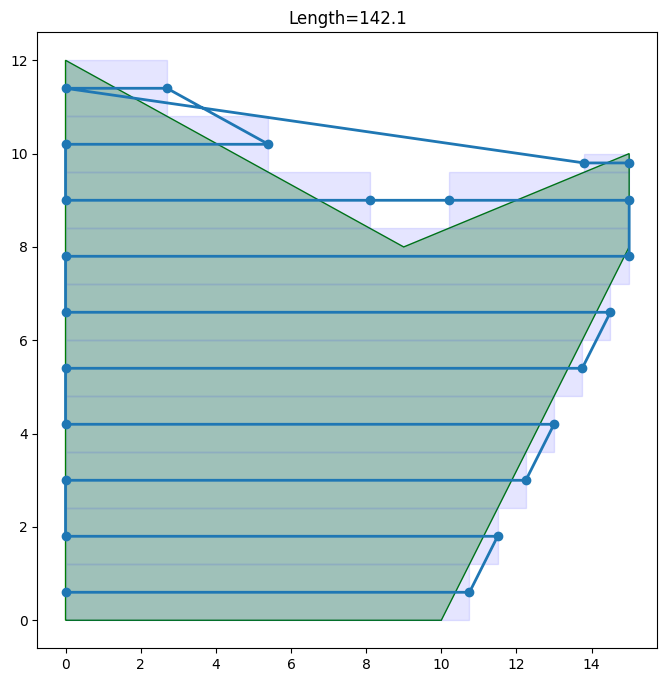

In [318]:
_, ax =plt.subplots(figsize=(8,8))
shapely.plotting.plot_polygon(my_poly,ax=ax,color='g',add_points=False)
shapely.plotting.plot_polygon(strips,ax=ax,color='b',alpha=0.1,add_points=False)
shapely.plotting.plot_line(path,ax=ax)
ax.set_title(f'Length={path.length:.1f}')

That is slightly better, but still obviously odd.  Better still would be to optimize the order - see later examples.

Sticking everything together, we can also include a rotation step, effectively working in a rotated reference frame to make our strips go in a preferred direction.

Text(0.5, 1.0, 'Length=162.8')

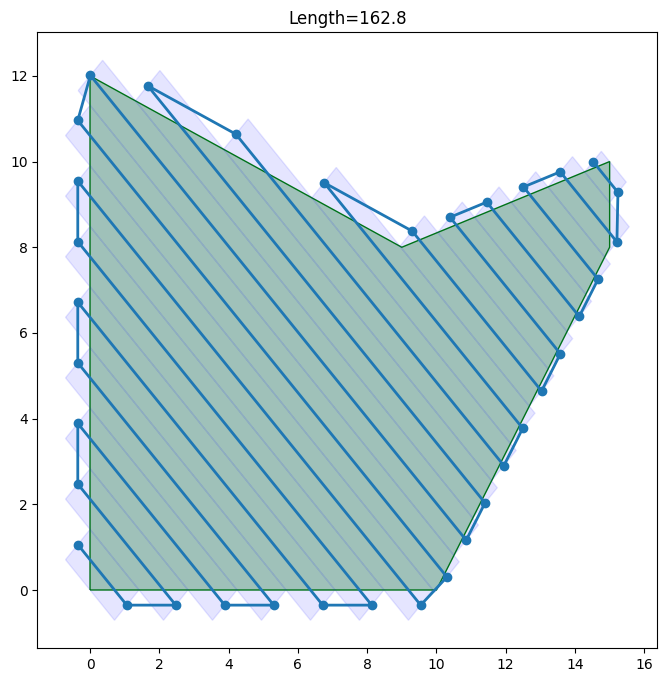

In [323]:
def lawnmower(poly,width,angle=0,use_radians=False):
    poly_r = shapely.affinity.rotate(poly,-angle,(0,0),use_radians=use_radians)
    splits_r = split_poly(poly_r,width)
    strips_r = make_strips(splits_r)
    path_r = build_path_greedy(strips_r)
    strips = shapely.affinity.rotate(strips_r,angle,(0,0))
    path = shapely.affinity.rotate(path_r,angle,(0,0))
    return path, strips

path, strips = lawnmower(my_poly,1,-45)
_, ax =plt.subplots(figsize=(8,8))
shapely.plotting.plot_polygon(my_poly,ax=ax,color='g',add_points=False)
shapely.plotting.plot_polygon(strips,ax=ax,color='b',alpha=0.1,add_points=False)
shapely.plotting.plot_line(path,ax=ax)
ax.set_title(f'Length={path.length:.1f}')

There are clearly some games to be played in optimizing the lawnmower to suit the field.  It gets even weirder when there's wind...